In [21]:
import sys
import numpy as np

sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug', '/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev', '/Users/david/Documents/mastersCode/ubm/final/models/hdphmm/hdphmmwl/testing', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm', '/Users/david/Documents/mastersCode/ubm']


In [22]:
import random
# Load state sequence and data from the pickle file
import pickle
with open('/Users/david/Documents/mastersCode/ubm/final/tests/train-test-val.pkl', 'rb') as file:
    sample_holder = pickle.load(file)

# with open('/Users/david/Documents/mastersCode/ubm/final/tests/comparison_of_fe_methods/samples_128_log_power.pickle', 'rb') as file:
#     sample_holder = pickle.load(file)

In [23]:
train = sample_holder['train']
val = sample_holder['val']
test = sample_holder['test']


In [24]:
from final import useful
def get_feature(samp):
    # add optionals here if needed
    # mfcc
    # feat = librosa.feature.mfcc(y=samp,sr=4000,n_mfcc=13).T
    feat = useful.get_log_power_feature(samp, nfft=128)
    return feat


In [36]:
import noisey

def get_noise_for_sample(sig_db, sample, snr_1=30, snr_2=30, snr_3=30):
    noise_power_1 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_1)
    noise_power_2 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_2)
    noise_power_3 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_3)

    noise_sample, _ = noisey.generate_gaussian_noise(len(sample), noise_power_1, noise_power_2, noise_power_3)
    return noise_sample

In [38]:
train.features = []
for i in range(len(train.samples)):

    # ---- noise / reverb adjustments ---- START
    noise_sample = get_noise_for_sample(-16, train.samples[i], 20, 15, 30)
    # noise_samples.append(noise_sample)
    # noise_features.append(get_feature(noise_sample))
    adjusted_sample = train.samples[i] + noise_sample
    # ---- noise / reverb adjustments ---- END
    train.features.append(get_feature(adjusted_sample))

val.features = []
for sample in val.samples:
    val.features.append(get_feature(sample))

test.features = []
for sample in test.samples:
    test.features.append(get_feature(sample))

In [39]:

def filter_features_by_label(sample_holder, label):
    indicis = sample_holder.sample_labels == label
    filtered_features = [item for item, condition in zip(sample_holder.features, indicis) if condition]
    return filtered_features

whale_label = 2

train_filtered_features = filter_features_by_label(train, whale_label)
val_filtered_features = filter_features_by_label(val, whale_label)
test_filtered_features = filter_features_by_label(test, whale_label)


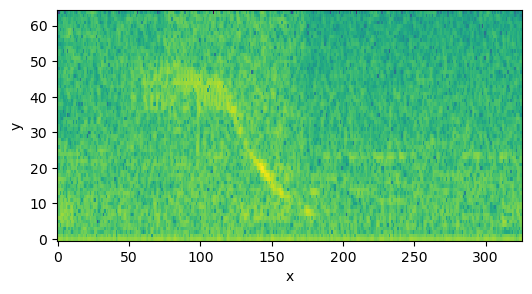

In [40]:
from final.useful import vis_helper

vis_helper(train_filtered_features[0])

In [41]:
# # get_log_power_feature()
# labels = np.array(sample_holder.sample_labels)
# samples = sample_holder.samples
# features = sample_holder.features
# from sklearn.utils import check_random_state
# rs = check_random_state(546)
# label = 1
# indices = np.array(labels == label)
# selected_features = [feats for feats, select in zip(features, indices) if select]
# lens = []
#
# for feat in selected_features[:5]:
#     lens.append(len(feat))
# lens = np.array(lens)
#
concatenated_list = [
    np.concatenate(random.sample(train_filtered_features, 8))
    for _ in range(10)
]

#
# train_filtered_features # + [train_filtered_features[2]]
#
#
#     [
#     np.concatenate(random.sample(train_filtered_features, 1))
#     for _ in range(10)
# ]

In [29]:
# init hmm
with open('/Users/david/Documents/mastersCode/ubm/final/models/hdphmm/hdphmmwl/testing/NoiseWhaleHMM.pkl', 'rb') as file:
    init_hmm = pickle.load(file)


In [42]:
import final.models.hdphmm.hdphmmwl.hdphmmwl_frozen as hdphmm
from final.models.hdphmm.helpers.plot_hmm import plot_hmm_data
import final.models.hdphmm.hdphmmwl.consts as const
import final.models.hdphmm.hdphmmwl.numba_wl as numba
from importlib import reload
reload(const)
reload(numba)
reload(hdphmm)

sbp = {
    const.ALPHA0: 100,
    const.GAMMA0: 1000,
    const.KAPPA0: 50,
}
sbp[const.RHO0] = sbp[const.KAPPA0] / ( sbp[const.KAPPA0] + sbp[const.ALPHA0])
temp = 1
hdp_hmm = hdphmm.HDPHMMWL(concatenated_list, 15, iterations=15, sbp=sbp, feature_a=11, feature_b=12, init_hmm=init_hmm)

# hdp_hmm.gamma0 = 0.01
# hdp_hmm.nu0 = 200
# hdp_hmm.V0 = np.eye(hdp_hmm.D) * 1000

sbp given


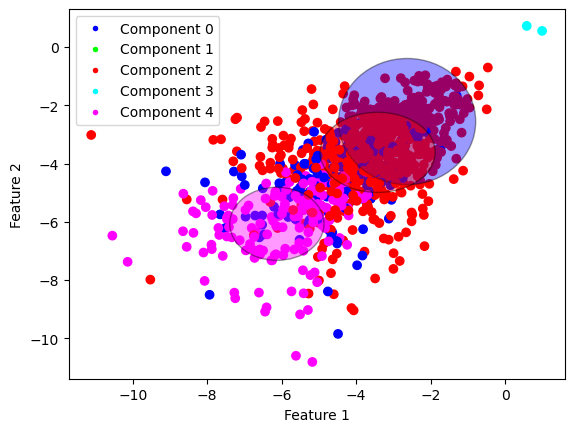

In [43]:
import final.models.hdphmm.helpers.plot_hmm as plot_hmm
reload(plot_hmm)
hdp_hmm.create_hmm()
hdp_hmm.plot_hmmlearn(15,16,1)

iterations per sample:  1
Gibb sampling on sample index:  0 outer it:  0
strating at k:  5
strating at k:  6
strating at k:  7
strating at k:  8
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
strating at k:  13
strating at k:  14
it:  0  || Likelihood:  -21939.36551501048  || n_components:  12
Gibb sampling on sample index:  1 outer it:  0
strating at k:  6
strating at k:  7
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
strating at k:  13
strating at k:  14
it:  0  || Likelihood:  -22267.386721794162  || n_components:  11
Gibb sampling on sample index:  2 outer it:  0
strating at k:  5
strating at k:  6
strating at k:  7
strating at k:  8
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
strating at k:  13
strating at k:  14
it:  0  || Likelihood:  -22259.114834438493  || n_components:  13
Gibb sampling on sample index:  3 outer it:  0
strating at k:  6
strating at k:  7
strating at k:  9
strating at k:  

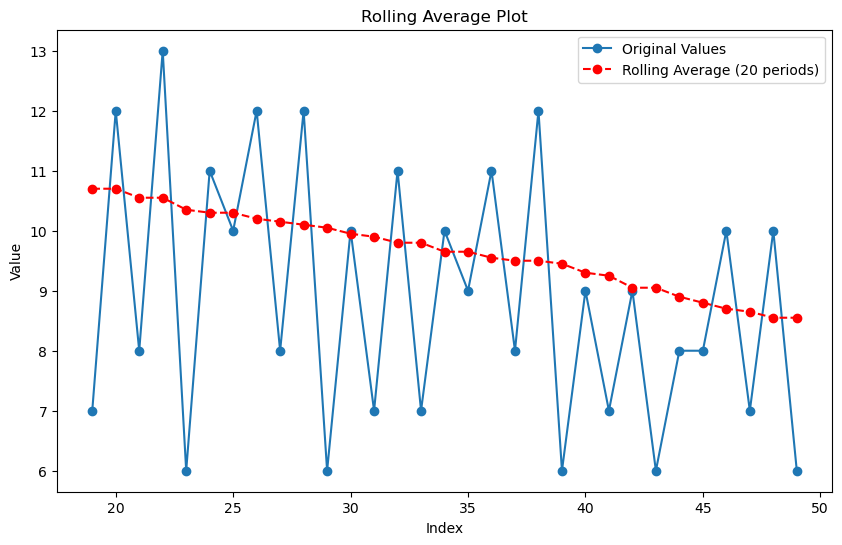

9.66
2.3376056125873754
Gibb sampling on sample index:  0 outer it:  5
strating at k:  5
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
strating at k:  14
it:  0  || Likelihood:  -22013.240177900105  || n_components:  9
Gibb sampling on sample index:  1 outer it:  5
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -22388.930562045494  || n_components:  7
Gibb sampling on sample index:  2 outer it:  5
strating at k:  5
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
strating at k:  14
it:  0  || Likelihood:  -22416.113662888572  || n_components:  9
Gibb sampling on sample index:  3 outer it:  5
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -22553.845493566012  || n_components:  6
Gibb sampling on sample index:  4 outer it:  5
strating at k:  5
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
strating at k:

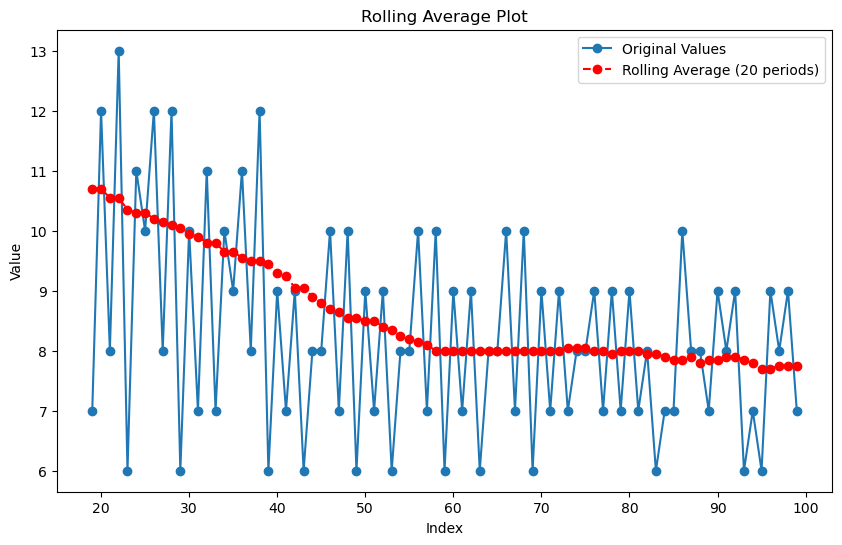

7.9
1.2206555615733703
Gibb sampling on sample index:  0 outer it:  10
strating at k:  7
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
strating at k:  14
it:  0  || Likelihood:  -22018.10757498534  || n_components:  9
Gibb sampling on sample index:  1 outer it:  10
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -22412.317583744556  || n_components:  7
Gibb sampling on sample index:  2 outer it:  10
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
strating at k:  14
it:  0  || Likelihood:  -22411.97213313505  || n_components:  8
Gibb sampling on sample index:  3 outer it:  10
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -22524.481839945704  || n_components:  6
Gibb sampling on sample index:  4 outer it:  10
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
strating at k:  14
it:  0  || Likelihood:  -2293

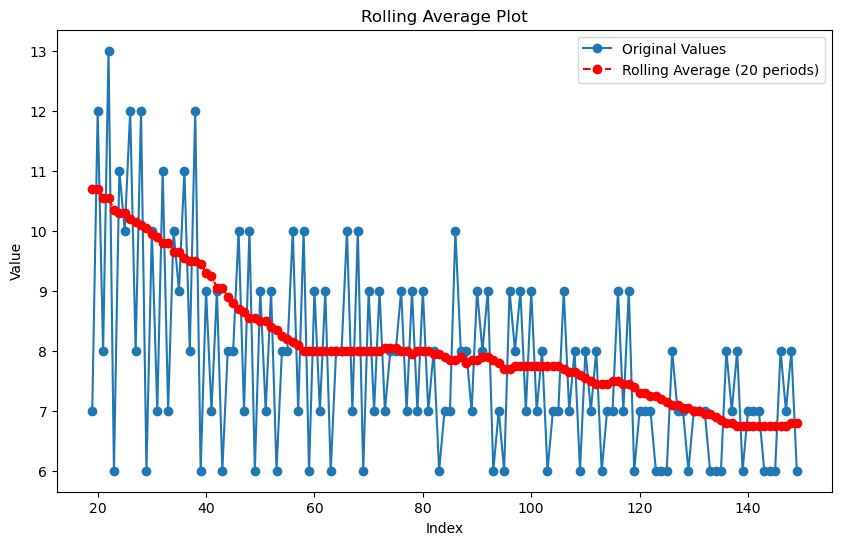

7.02
0.905317623820502
7.46
1.1612062693595828
Gibb sampling on sample index:  0 outer it:  15
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -21990.136934698672  || n_components:  7
Gibb sampling on sample index:  1 outer it:  15
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -22377.142884796685  || n_components:  7
Gibb sampling on sample index:  2 outer it:  15
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -22418.27963889181  || n_components:  7
Gibb sampling on sample index:  3 outer it:  15
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -22535.46799280836  || n_components:  6
Gibb sampling on sample index:  4 outer it:  15
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -23048.722714325322  || n_components:  6
Gibb sampling o

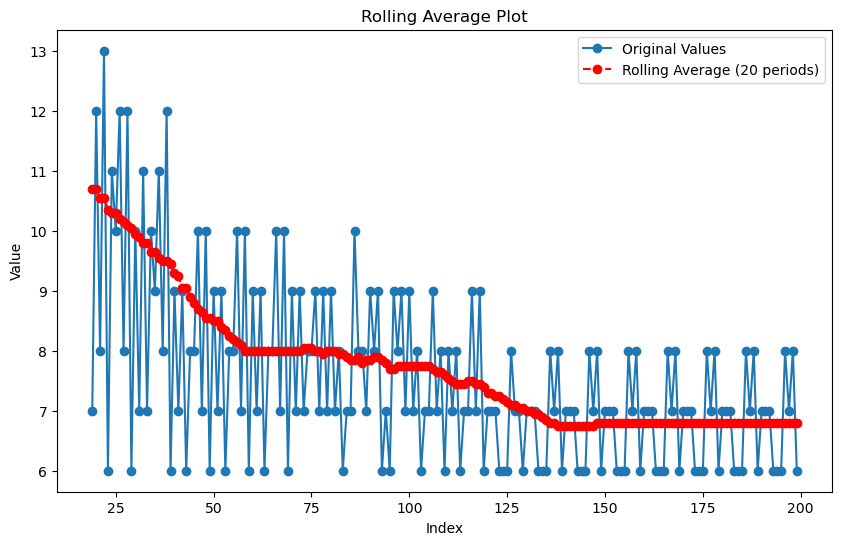

6.8
0.7483314773547883
6.91
0.8377947242612598
Gibb sampling on sample index:  0 outer it:  20
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -21985.413163718982  || n_components:  7
Gibb sampling on sample index:  1 outer it:  20
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -22411.123603899352  || n_components:  7
Gibb sampling on sample index:  2 outer it:  20
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -22414.651000385886  || n_components:  7
Gibb sampling on sample index:  3 outer it:  20
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -22532.76163630853  || n_components:  6
Gibb sampling on sample index:  4 outer it:  20
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -22971.7233827202  || n_components:  6
Gibb sampling on

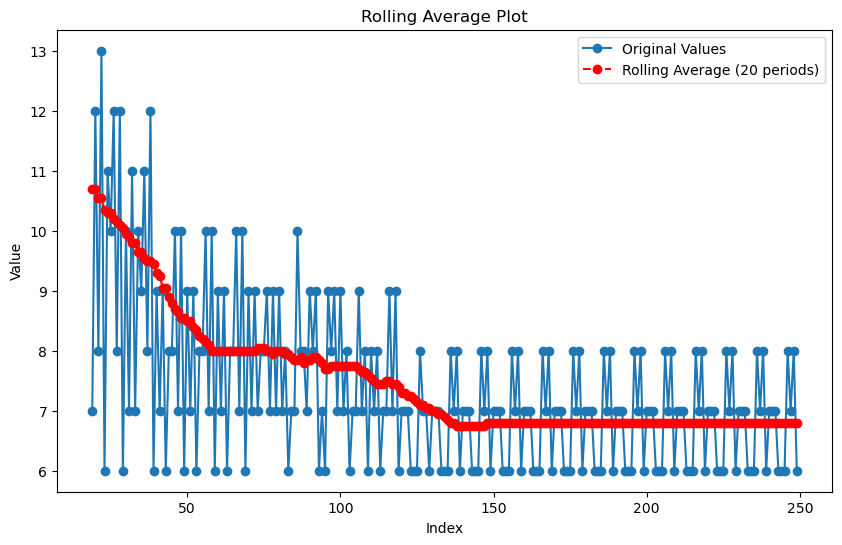

6.8
0.7483314773547883
6.8
0.7483314773547882
Gibb sampling on sample index:  0 outer it:  25
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -21996.334595856275  || n_components:  7
Gibb sampling on sample index:  1 outer it:  25
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -22405.47177382765  || n_components:  7
Gibb sampling on sample index:  2 outer it:  25
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -22407.72850041158  || n_components:  7
Gibb sampling on sample index:  3 outer it:  25
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -22537.77366041156  || n_components:  6
Gibb sampling on sample index:  4 outer it:  25
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -22939.182102304116  || n_components:  6
Gibb sampling on 

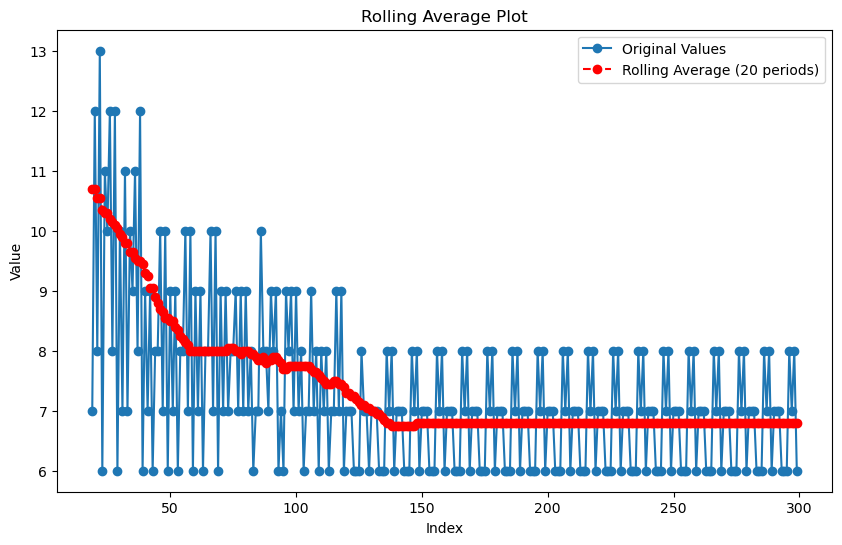

6.8
0.7483314773547883
6.8
0.7483314773547882
Gibb sampling on sample index:  0 outer it:  30
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -21996.68677645419  || n_components:  7
Gibb sampling on sample index:  1 outer it:  30
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -22417.1140130368  || n_components:  7
Gibb sampling on sample index:  2 outer it:  30
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -22388.3433141202  || n_components:  7
Gibb sampling on sample index:  3 outer it:  30
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -22529.22333797017  || n_components:  6
Gibb sampling on sample index:  4 outer it:  30
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -22937.479475533688  || n_components:  6
Gibb sampling on sam

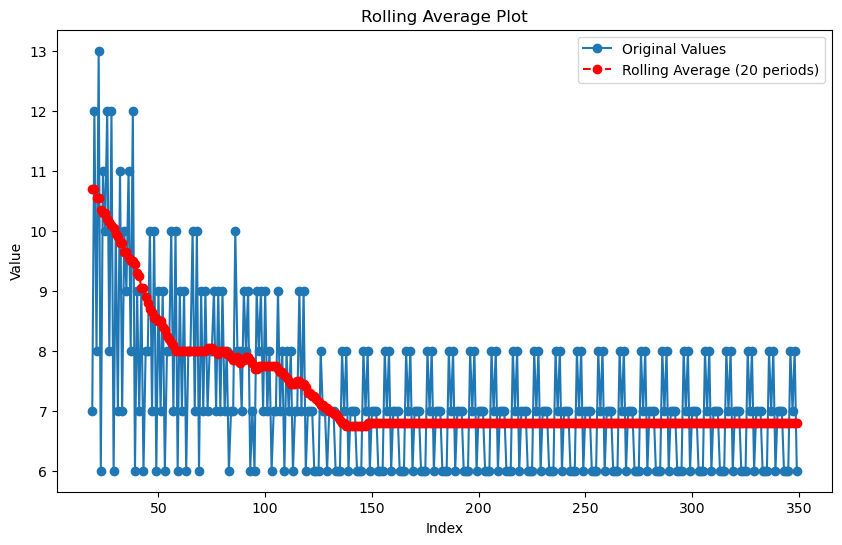

6.8
0.7483314773547883
6.8
0.7483314773547882
Gibb sampling on sample index:  0 outer it:  35
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -22014.119546457918  || n_components:  7
Gibb sampling on sample index:  1 outer it:  35
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -22396.61012787752  || n_components:  7
Gibb sampling on sample index:  2 outer it:  35
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -22422.233284035658  || n_components:  7
Gibb sampling on sample index:  3 outer it:  35
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -22554.853441539184  || n_components:  6
Gibb sampling on sample index:  4 outer it:  35
strating at k:  9
strating at k:  10
strating at k:  11
strating at k:  12
it:  0  || Likelihood:  -22949.589711677676  || n_components:  6
Gibb sampling o

KeyboardInterrupt: 

In [44]:
hdp_hmm.fit_multiple(verbose=True, outer_its=50, iterations=1, burn_in=1)

# plt.plot(range(0,len(hdp_hmm.trace[const.TIME])), hdp_hmm.trace[const.TIME], marker="None")
# plt.xlabel('iteration')
# plt.ylabel('ARI')
# plt.xlim(0,1)
# #plt.savefig("./image/ari.png")
# plt.show()
# plt.close()
print('average time for one gibbs sweep: ', np.mean(hdp_hmm.trace[const.TIME]))

In [45]:
useful.find_similar_states_kl(hdp_hmm.hmm, init_hmm)

array([[ 20.07795738,  65.77918326,   0.        , 189.94567249,
         74.91811934],
       [ 50.47739649, 137.43530852, 126.98199009, 459.28473075,
          0.        ],
       [ 41.84600221, 125.43957517,  54.66450464, 298.21595954,
         69.54991846],
       [ 62.70363324, 171.54482005,  56.36217734, 244.69962136,
        160.73663424],
       [ 41.16678846, 117.09380425,  14.8878221 , 185.2026329 ,
        133.51539127],
       [ 66.09087932, 180.13558932,  42.60484988, 194.40284186,
        204.73356267]])

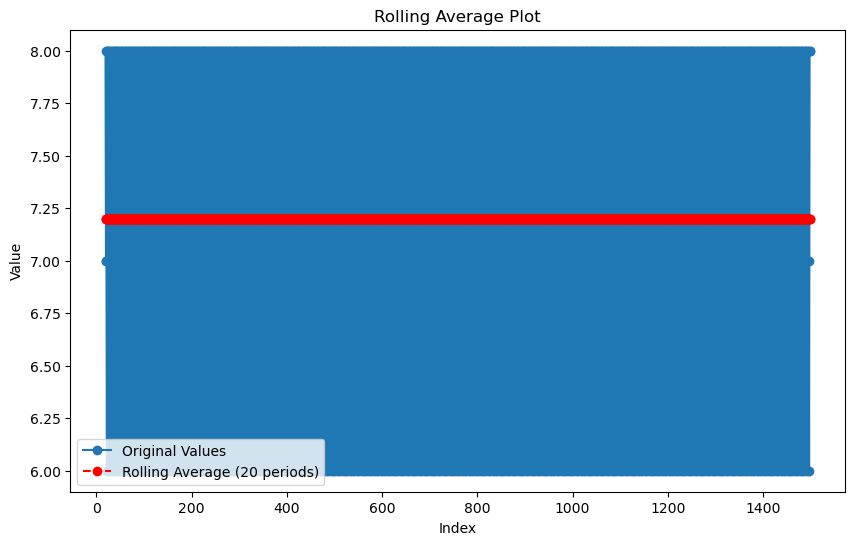

In [160]:
import matplotlib.pyplot as plt

data = hdp_hmm.trace['n_components_all']
# Define the window size for the rolling average
window_size = 20

# Create a kernel for the rolling average
kernel = np.ones(window_size) / window_size

# Use np.convolve to calculate the rolling average
rolling_avg = np.convolve(data, kernel, mode='valid')

# Create an array of indices corresponding to the original data for plotting
indices = np.arange(window_size - 1, len(data))

# Plot the data and rolling average
plt.figure(figsize=(10, 6))
plt.plot(indices, data[window_size - 1:], label='Original Values', marker='o')
plt.plot(indices, rolling_avg, label=f'Rolling Average ({window_size} periods)', color='red', linestyle='--', marker='o')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Rolling Average Plot')
plt.legend()
plt.show()

In [21]:
np.mean(hdp_hmm.trace['n_components'])

3.845082433200682

In [22]:
trace = hdp_hmm.trace

In [23]:
nk = np.copy(trace['nk'])[-100:]
nk_sum = np.sum(nk, axis=0)

In [24]:
from hmmlearn.hmm import GaussianHMM
# create am hmm from the trace
def hmm_from_trace(n_components, average_over=100):

    # from the last 'average_over' its, get the sum
    nk = np.copy(trace['nk'])[-average_over:]
    nk_sum = np.sum(nk, axis=0)

    largest_indices = np.argpartition(nk_sum, -n_components)[-n_components:]
    # nk_sum_norm = (nk_sum / np.sum(nk_sum)) * 100

    mu_matrix = np.mean(np.array(trace['mu'][-average_over:]), axis=0)[largest_indices]
    sigma_matrix = np.mean(np.array(trace['covar'][-average_over:]), axis=0)[largest_indices]
    A = np.mean(np.array(trace['A'][-average_over:]), axis=0)[largest_indices][:, largest_indices]
    pi = np.mean(np.array(trace['pie'][-average_over:]), axis=0)[largest_indices]

    hmm_trace = GaussianHMM(len(largest_indices), covariance_type='diag')
    hmm_trace.n_features = mu_matrix.shape[1]
    hmm_trace.transmat_, hmm_trace.startprob_, hmm_trace.means_ = hdp_hmm.normalize_matrix(A), hdp_hmm.normalize_matrix(pi), mu_matrix
    hmm_trace.covars_ = np.array([np.diag(i) for i in sigma_matrix])

    return hmm_trace

new_hmm_trace = hmm_from_trace(5, average_over=100)
# rem_ind = zero_indices.astype(int)
# A = A[rem_ind][:, rem_ind]
# pi = pi[rem_ind]
# means = means[rem_ind]
# covar = covar[rem_ind]
# n_components = len(rem_ind)

In [31]:
# save humpback whale pickle

# print("Writing to pickle file: " + BASENAME + ".pkl")
output = open('NoiseWhaleHMM' + ".pkl", "wb")
pickle.dump(new_hmm_trace, output)

In [165]:
# hmm check
# with open('/Users/david/Documents/mastersCode/ubm/final/models/hdphmm/hdphmmwl/testing/BowheadWhaleHMM.pkl', 'rb') as file:
#     hmm_check = pickle.load(file)

In [115]:
mu_smaller = trace['mu'][-300:]
# index 2 is largest

In [116]:
feature_index_a = 14
feature_index_b = 15
mu_feature_index_a = []
mu_feature_index_b = []
for i in range(len(mu_smaller)):
    curr_mu = mu_smaller[i]
    mu_feature_index_a.append(curr_mu[14][14])
    mu_feature_index_b.append(curr_mu[14][15])

In [ ]:
import matplotlib.pyplot as plt

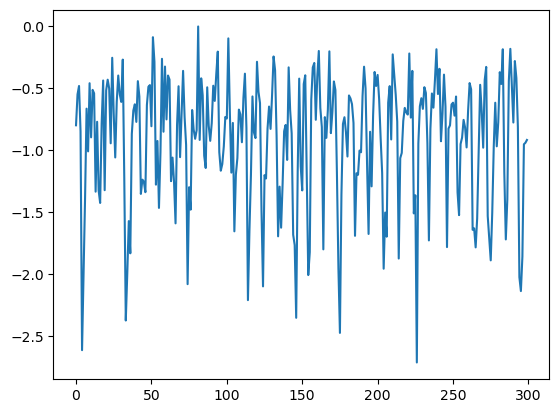

In [117]:
# plt.scatter(mu_feature_index_a, mu_feature_index_b)
plt.plot(mu_feature_index_a)
plt.show()

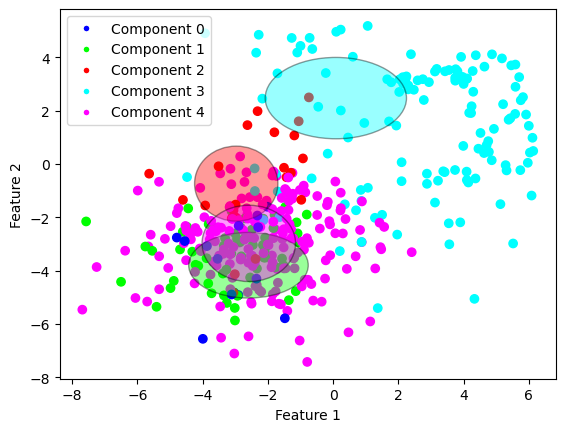

In [119]:
plot_hmm.plot_hmm_learn(concatenated_list[0], hdp_hmm.hmm, 5, 14, 16)

In [25]:
from hmmlearn.hmm import GaussianHMM
hdp_hmm.create_hmm()
hmm_hdp_diag = hdp_hmm.hmm
hdp_hmm.create_hmm('full')
hmm_hdp_full = hdp_hmm.hmm
hdp_hmm.create_hmm()

In [26]:
hmm_hdp_diag.fit(np.concatenate(train_filtered_features))
hmm_hdp_full.fit(np.concatenate(train_filtered_features))

GaussianHMM(covariance_type='full', init_params='', n_components=2)

In [27]:
hmm_em_diag = GaussianHMM(5, covariance_type='diag')
hmm_em_diag.fit(np.concatenate(train_filtered_features))
hmm_em_full = GaussianHMM(5, covariance_type='full')
hmm_em_full.fit(np.concatenate(train_filtered_features))

GaussianHMM(covariance_type='full', n_components=5)

In [28]:
print('hdp_hmm          ', hdp_hmm.hmm.score(test_filtered_features[0]))
print('hdp_hmm trace:   ', new_hmm_trace.score(test_filtered_features[0]))
print('hdp_hmm diag:    ', hmm_hdp_diag.score(test_filtered_features[0]))
print('hdp_hmm full:    ', hmm_hdp_full.score(test_filtered_features[0]))
print('hmm_em diag:     ', hmm_em_diag.score(test_filtered_features[0]))
print('hmm_em full:     ', hmm_em_full.score(test_filtered_features[0]))

hdp_hmm           -39570.36789360779
hdp_hmm trace:    -39185.24792492662
hdp_hmm diag:     -39185.39937316695
hdp_hmm full:     -37247.746620267055
hmm_em diag:      -38732.71457642562
hmm_em full:      -37310.40653113629


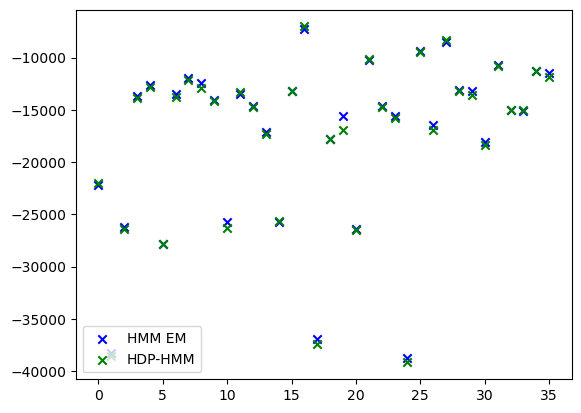

In [29]:
hmm_em_diag_lik = []
hmm_em_full_lik = []
hdp_hmm_lik = []
hdp_hmm_trace_lik = []
hmm_hdp_diag_lik = []
hmm_hdp_covar_lik = []

val_test_concat = val_filtered_features + test_filtered_features

for i in range(len(val_test_concat)):
    hmm_em_diag_lik.append(hmm_em_diag.score(val_test_concat[i]))
    hmm_em_full_lik.append(hmm_em_full.score(val_test_concat[i]))
    hdp_hmm_lik.append(hdp_hmm.hmm.score(val_test_concat[i]))
    hdp_hmm_trace_lik.append(new_hmm_trace.score(val_test_concat[i]))
    hmm_hdp_diag_lik.append(hmm_hdp_diag.score(val_test_concat[i]))
    hmm_hdp_covar_lik.append(hmm_hdp_full.score(val_test_concat[i]))

import matplotlib.pyplot as plt
x_axis = np.arange(len(hdp_hmm_lik))
plt.xlim()

# plt.scatter(x_axis, hmm_hdp_covar_lik, label='HDP-HMM EM full', c='r', marker='o')
# plt.scatter(x_axis, hmm_hdp_diag_lik, label='HDP-HMM Em diag', c='r', marker='o')
#
# plt.scatter(x_axis, hmm_em_full_lik, label='HMM full', c='blue', marker='x')
plt.scatter(x_axis, hmm_em_diag_lik, label='HMM EM', c='blue', marker='x')

# plt.scatter(x_axis, hdp_hmm_lik, label='HDP-HMM', c='grey')
plt.scatter(x_axis, hdp_hmm_trace_lik, label='HDP-HMM', c='g', marker='x')

plt.legend(loc='lower left')

In [126]:
np.exp(hdp_hmm_lik[1])

0.0

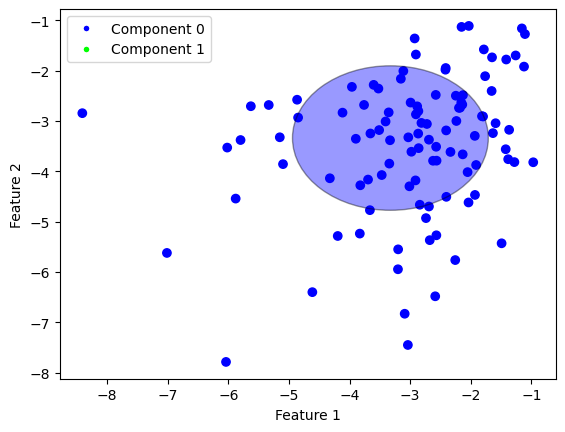

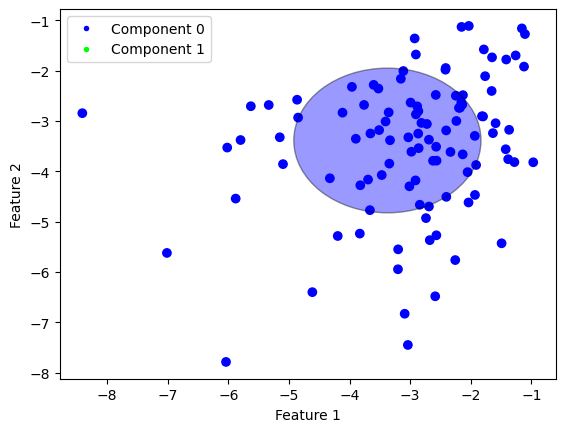

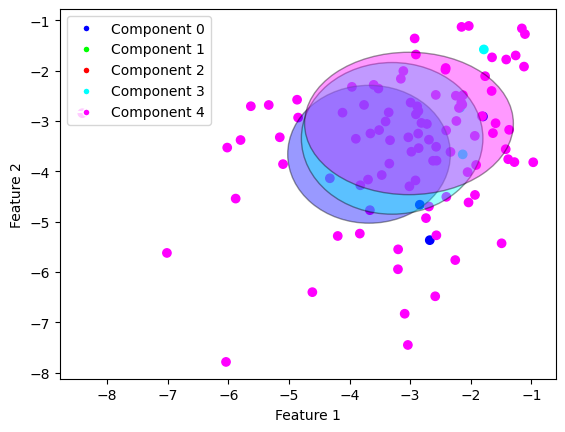

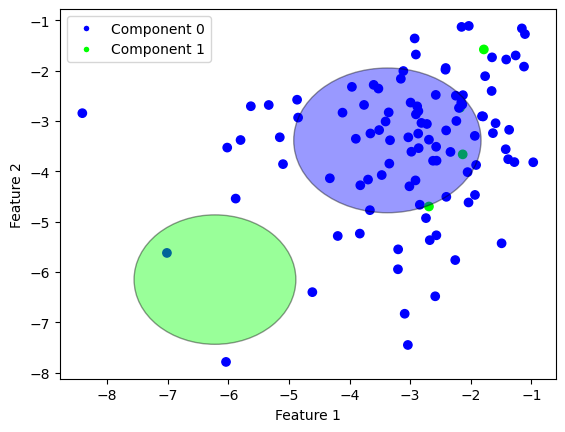

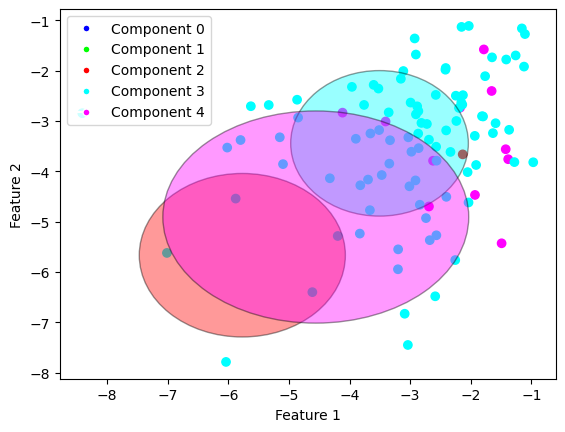

In [30]:
import final.models.hdphmm.helpers.plot_hmm as plot_hmm
reload(plot_hmm)
plot_hmm.plot_hmm_learn(test_filtered_features[-1], hdp_hmm.hmm, 0.1, 14, 13)
plot_hmm.plot_hmm_learn(test_filtered_features[-1], hmm_hdp_diag, 0.1, 14, 13)
plot_hmm.plot_hmm_learn(test_filtered_features[-1], hmm_em_diag, 0.1, 14, 13)
plot_hmm.plot_hmm_learn(test_filtered_features[-1], hmm_hdp_full, 0.1, 14, 13)
plot_hmm.plot_hmm_learn(test_filtered_features[-1], hmm_em_full, 0.1, 14, 13)

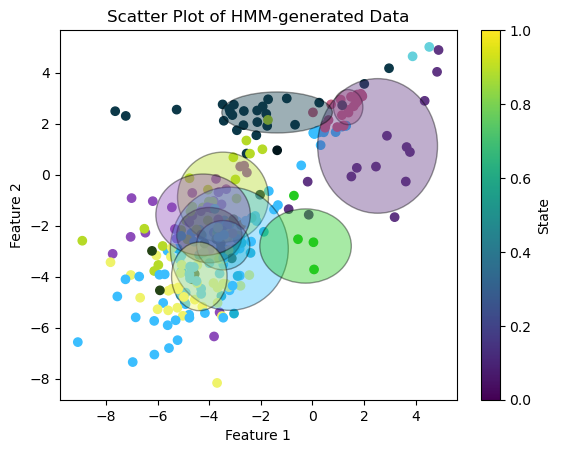

In [105]:
plot_hmm.plot_hmm_data(aic_states_humpback[3], hdp_hmm.Z, hdp_hmm.K, hdp_hmm.mu, hdp_hmm.sigma, counts=hdp_hmm.nk, percent=1,feature_a=11, feature_b=12)

In [46]:
gibbs_hmm = hdp_hmm.hmm
em_hmm = GaussianHMM(10, covariance_type='diag')
em_hmm.fit(smaller_features)
ll_gibbs, _ = gibbs_hmm.decode(smaller_features)
ll_em, ss_em = em_hmm.decode(smaller_features)
print('gibbs: ', ll_gibbs, 'em: ', ll_em)

gibbs:  -26370.479803144364 em:  -26718.644665980133


In [47]:
gibbs_hmm.fit(smaller_features)

GaussianHMM(init_params='', n_components=18)

In [48]:
ll_gibbs, _ = gibbs_hmm.decode(smaller_features)
ll_em, ss_em = em_hmm.decode(smaller_features)
print('gibbs: ', ll_gibbs, 'em: ', ll_em)

gibbs:  -24635.587943985214 em:  -26718.644665980133


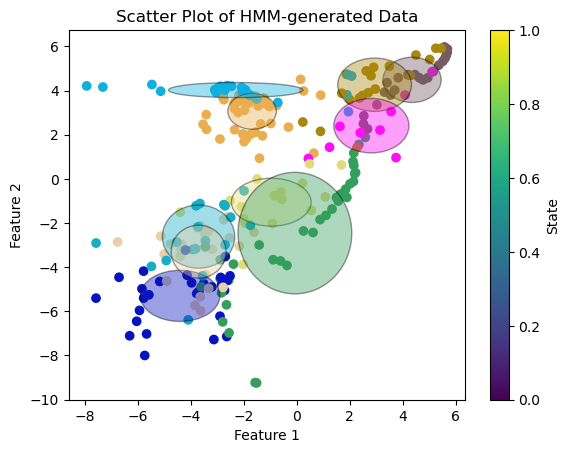

In [49]:
import final.models.hdphmm.helpers.plot_hmm as plot_hmm
reload(plot_hmm)
plot_hmm.plot_hmm_data(smaller_features, ss_em, em_hmm.n_components, em_hmm.means_, em_hmm.covars_, feature_a=11, feature_b=12)